In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding="latin1")

# For some reasons, the column names must be "text" and "label".
dataset = pd.DataFrame(raw, columns=["v1","v2"]).rename(columns={"v1": "label", "v2": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})

train, test = train_test_split(dataset, test_size=.25, random_state=42)

In [ ]:
# import torch
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
from datasets import Dataset

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_set = Dataset.from_pandas(train)
test_set = Dataset.from_pandas(test)

train_set = train_set.map(
    lambda row : tokenizer(row["text"], truncation=True, padding="max_length", max_length=128),
    batched=True
)
test_set = test_set.map(
    lambda row : tokenizer(row["text"], truncation=True, padding="max_length", max_length=128),
    batched=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/4179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1393 [00:00<?, ? examples/s]

In [ ]:
# import torch
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
from datasets import Dataset
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)
import numpy as np

def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  labels = pred.label_ids

  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

train_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

roberta = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir="/content/drive/MyDrive/Colab Notebooks/log",
    save_total_limit=1,
    report_to="none",
    learning_rate=1e-5,
)

trainer = Trainer(
    model=roberta,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.108400,0.046685,0.993539,0.994565,0.958115,0.976000
2,0.032800,0.038365,0.994975,1.000000,0.963351,0.981333


TrainOutput(global_step=1046, training_loss=0.06795942749165668, metrics={'train_runtime': 241.1462, 'train_samples_per_second': 34.659, 'train_steps_per_second': 4.338, 'total_flos': 549770550174720.0, 'train_loss': 0.06795942749165668, 'epoch': 2.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.03613628074526787, 'eval_accuracy': 0.9935391241923905, 'eval_precision': 0.9840425531914894, 'eval_recall': 0.9685863874345549, 'eval_f1': 0.9762532981530343, 'eval_runtime': 8.7881, 'eval_samples_per_second': 158.51, 'eval_steps_per_second': 19.913, 'epoch': 3.0}


Eval phase

In [ ]:
from transformers import (RobertaTokenizer, RobertaForSequenceClassification)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
# from datasets import Dataset
# from torch.utils.data import DataLoader, TensorDataset

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results/checkpoint-1046"
trained_roberta = RobertaForSequenceClassification.from_pretrained(checkpoint)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
trained_roberta.eval()

# raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding="latin1")
# dataset = pd.DataFrame(raw, columns=["v1","v2"]).rename(columns={"v1": "label", "v2": "text"})
raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SPAM text message 20170820 - Data.csv", encoding="latin1")
dataset = pd.DataFrame(raw, columns=["Category","Message"]).rename(columns={"Category": "label", "Message": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})
train, test = train_test_split(dataset, test_size=.16, random_state=42)

# inputs = Dataset.from_pandas(raw_dataset)
# inputs = inputs.map(
#     lambda row : tokenizer(row["text"], truncation=True, padding="max_length", max_length=128),
#     batched=True
# )

# dataset = TensorDataset(inputs["inputs_id"], inputs["attention_mask"], torch.tensor(raw_dataset["label"]))
# dataloader = DataLoader(dataset, batch_size=32)

# predictions = []

inputs = tokenizer(test["text"].tolist(), truncation=True, padding=True, return_tensors="pt")
with torch.no_grad():
    outputs = trained_roberta(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)


KeyboardInterrupt: 

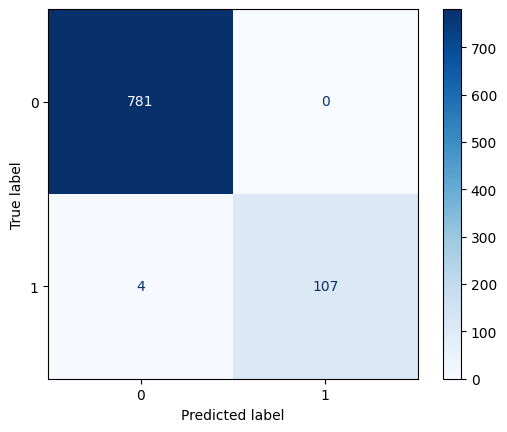

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(test["label"], predictions.numpy())

ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(values_format="d", cmap="Blues")
plt.show()

Prediction

In [ ]:
from transformers import (RobertaTokenizer, RobertaForSequenceClassification)
import torch

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results/checkpoint-1046"
trained_roberta = RobertaForSequenceClassification.from_pretrained(checkpoint)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
trained_roberta.eval()

def predict(msg:str):
  input = tokenizer(msg, truncation=True, padding=True, return_tensorsu"pt")
  with torch.no_grad():
    output = trained_roberta(**input)
  proba = torch.softmax(output.logits, dim=1)
  prediction = torch.argmax(proba).item()
  return prediction, proba.squeeze().tolist()

In [ ]:
ham_test = "K I'll call you when I'm close"
spam_test = "Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"
pred, prob = predict(spam_test)
print({"Prediction": pred, "Probability": prob})

{'Prediction': 1, 'Probability': [0.00019619014346972108, 0.9998038411140442]}


# ROC Curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.nn.functional import softmax

def get_probabilities(model, tokenizer, texts):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for t in texts:
            inputs = tokenizer(t, return_tensors="pt", truncation=True)
            outputs = model(**inputs)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            all_probs.append(probs[0,1].item())
    return all_probs


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from transformers import (RobertaTokenizer, RobertaForSequenceClassification)

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results/checkpoint-1046"
trained_roberta = RobertaForSequenceClassification.from_pretrained(checkpoint)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding="latin1")
dataset = pd.DataFrame(raw, columns=["v1","v2"]).rename(columns={"v1": "label", "v2": "text"})
# raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SPAM text message 20170820 - Data.csv", encoding="latin1")
# dataset = pd.DataFrame(raw, columns=["Category","Message"]).rename(columns={"Category": "label", "Message": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})
y_true = dataset["label"].tolist()

roberta_probs = get_probabilities(trained_roberta, tokenizer, dataset["text"].tolist())

fpr_r, tpr_r, _ = roc_curve(y_true, roberta_probs)
roc_auc_r = auc(fpr_r, tpr_r)

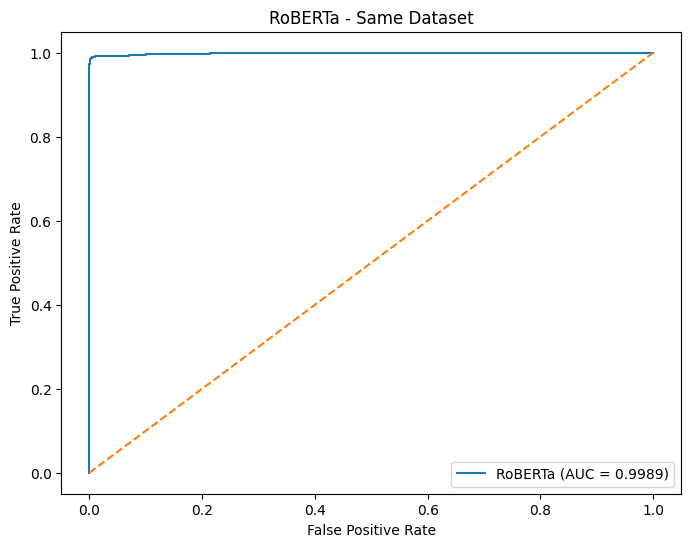

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(fpr_r, tpr_r, label=f"RoBERTa (AUC = {roc_auc_r:.4f})")

plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RoBERTa - Same Dataset")
plt.legend(loc="lower right")

plt.show()